In [1]:
#hide
#skip
%config Completer.use_jedi = False
%config IPCompleter.greedy=True
# upgrade fastrl on colab
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
# hide
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
# default_exp agents.core

In [9]:
# export
# Python native modules
import os
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
import torch
from fastai.torch_basics import *
from fastai.torch_core import *
# Local modules
from fastrl.core import *
from fastrl.pipes.core import *
from fastrl.pipes.map.demux import *
from fastrl.pipes.map.mux import *

# Agent Core
> Minimum Agent DataPipes, objects, and utilities

In [102]:
# export
class AgentBase(dp.iter.IterDataPipe):
    def __init__(self,
            model:Module, # The base NN that we getting raw action values out of.
            action_iterator:list=None # A reference to an iterator that contains actions to process.
    ):
        self.model = model
        self.iterable = ifnone(action_iterator,[])
        self.agent_base = self
        
    def __iter__(self):
        while self.iterable:
            yield self.iterable.pop(0)
            
add_docs(
    AgentBase,
    """Acts as the footer of the Agent pipeline. 
    Maintains important state such as the `model` being used for get actions from.
    Also optionally allows passing a reference list of `action_iterator` which is a
    persistent list of actions for the entire agent pipeline to process through.
    
    > Important: Must be at the start of the pipeline, and be used with AgentHead at the end.
    
    > Important: `action_iterator` is stored in the `iterable` field. However the recommended
    way of passing actions to the pipeline is to call an `AgentHead` instance.
    """
    
)            
            
def is_agent_base(pipe): return isinstance(pipe,AgentBase)
def find_agent_base(pipe):
    "Basically just find_pipes+is_agent_base with exception handling"
    agent_base = find_pipes(pipe,is_agent_base)
    if not agent_base:
        raise Exception('`AgentBase` must be at the start of the pipeline, but it seems to be missing.')
    return agent_base[0]

class AgentHead(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe): 
        self.source_datapipe = source_datapipe
        self.agent_base = find_agent_base(self.source_datapipe)
        
    def __call__(self,actions:list): 
        self.agent_base.iterable.extend(actions)
        return self
    
    def __iter__(self): yield from self.source_datapipe
        
add_docs(
    AgentHead,
    """Acts as the head of the Agent pipeline. 
    Used for conveniently adding actions to the pipeline to process.
    
    > Important: Must be paired with `AgentBase`
    """
)  

In [103]:
from torch.nn import *
from torch.optim import *
from fastai.torch_basics import *
from fastai.torch_core import *

class DQN(Module):
    def __init__(self,state_sz:int,action_sz:int,hidden=512):
        self.layers=Sequential(
            Linear(state_sz,hidden),
            ReLU(),
            Linear(hidden,action_sz),
        )
    def forward(self,x): return self.layers(x)

class SimpleModelRunner(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe): 
        self.source_datapipe = source_datapipe
        self.agent_base = find_agent_base(self.source_datapipe)
    
    def __iter__(self):
        for o in self.source_datapipe: 
            try: yield self.agent_base.model(o)
            except Exception:
                print('Failed on ',o)
                raise

In [104]:
# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the agent
agent = AgentBase(model,[])
# All the things that make this agent unique and special
# In this instance, all this module does is pass the action directly through to the model.
agent = SimpleModelRunner(agent)
# Bring everything together into the AgentHead where actions will be passed and then run through the pipeline
agent = AgentHead(agent)

If we pass a list of tensors, we will get a list of actions:

In [108]:
for action in agent([tensor([1,2,3,4]).float()]):
    print(action)

tensor([-0.2909, -1.0357], grad_fn=<AddBackward0>)


In [109]:
for action in agent([tensor([1,2,3,4]).float()]*3):
    print(action)

tensor([-0.2909, -1.0357], grad_fn=<AddBackward0>)
tensor([-0.2909, -1.0357], grad_fn=<AddBackward0>)
tensor([-0.2909, -1.0357], grad_fn=<AddBackward0>)


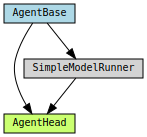

In [110]:
from torchdata.datapipes.utils import to_graph
to_graph(agent)

In [ ]:
# export
class DiscreteEpsilonRandomSelect(dp.iter.IterDataPipe):
    debug=False
    def __init__(self,source_datapipe,agent_base,n_actions,idx=0,min_epsilon=0.2,max_epsilon=1,max_steps=5000):
        self.n_actions = n_actions
        self.source_datapipe = source_datapipe
        self.agent_base = agent_base
        self.agent_base.epislon_selector = self 
        self.min_epsilon = min_epsilon
        self.epsilon = max_epsilon
        self.max_epsilon = max_epsilon
        self.max_steps = max_steps
        self.idx = idx
    
    def __iter__(self):
        for action in self.source_datapipe:
            mask = np.random.random(size=self.n_actions) < self.epsilon
            rand_actions = np.random.choice(self.n_actions, sum(mask))
            action = action.cpu().detach().numpy().reshape((-1,))
            action[mask] = rand_actions
            action=Tensor(action).long().reshape(-1,1)

            if self.agent_base.model.training: 
                self.idx += 1
                self.epsilon = max(self.min_epsilon,self.max_epsilon-self.idx/self.max_steps)
            yield action

In [ ]:
# export
from torch.nn import *
from torch.optim import *
from fastai.torch_basics import *
from fastai.torch_core import *

class DQN(Module):
    def __init__(self,state_sz:int,action_sz:int,hidden=512):
        self.layers=Sequential(
            Linear(state_sz,hidden),
            ReLU(),
            Linear(hidden,action_sz),
        )
    def forward(self,x): return self.layers(x)


class RawOutOfStep(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,agent_base,key): 
        self.source_datapipe = source_datapipe
        self.key = key
        self.agent_base = agent_base
        
    def __iter__(self):
        for o in self.source_datapipe:
            x = tensor(o[self.key])
            x = self.agent_base.model(x)
            yield x
            
class ArgmaxOfStep(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,agent_base): 
        self.source_datapipe = source_datapipe
        self.agent_base = agent_base
        
    def __iter__(self):
        for o in self.source_datapipe:
            yield torch.argmax(o)
            
class ToDiscrete(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,agent_base): 
        self.source_datapipe = source_datapipe
        self.agent_base = agent_base
        
    def __iter__(self):
        for x in self.source_datapipe:
            if isinstance(x,Tensor):
                if len(x.shape)==0:
                    yield int(x)
                else:
                    yield x.long()
            else:
                raise Exception(f'Cant convert to discrete: {x}')

In [ ]:
# Setup up the core NN
model = DQN(4,2)
# Setup the agent
agent_base = Agent(model,[])
agent = RawOutOfStep(agent_base,agent_base,'state')
agent_ep = DiscreteEpsilonRandomSelect(agent,agent_base,2,min_epsilon=0)
agent = ArgmaxOfStep(agent_ep,agent_base)
agent = ToDiscrete(agent,agent_base)

In [ ]:
# hide
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.export import *
    from nbdev.export2html import *
    from nbdev.cli import *
    make_readme()
    notebook2script(silent=True)